# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW08] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter, defaultdict
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List, Iterable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [3]:
def gini(x: np.ndarray) -> float:
    """
    Считает коэффициент Джини для массива меток x.
    """
    _, counts = np.unique(x, return_counts=True)
    probs = counts / len(x)
    return probs @ (1. - probs)


def entropy(x: np.ndarray) -> float:
    """
    Считает энтропию для массива меток x.
    """
    _, counts = np.unique(x, return_counts=True)
    probs = counts / len(x)
    return -(probs @ np.log2(probs))


def gain(left_y: np.ndarray, right_y: np.ndarray, criterion: Callable) -> float:
    """
    Считает информативность разбиения массива меток.

    Parameters
    ----------
    left_y : np.ndarray
        Левая часть разбиения.
    right_y : np.ndarray
        Правая часть разбиения.
    criterion : Callable
        Критерий разбиения.
    """
    n = len(left_y) + len(right_y)
    return criterion(np.hstack([left_y, right_y])) \
           - len(left_y) * criterion(left_y) / n \
           - len(right_y) * criterion(right_y) / n

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__

In [4]:
class DecisionTreeLeaf:
    """

    Attributes
    ----------
    y : Тип метки (напр., int или str)
        Метка класса, который встречается чаще всего среди элементов листа дерева
    """

    def __init__(self, y):
        counter = Counter(y)
        self.y = counter.most_common(1)[0][0]
        n = len(y)
        self.probs = {label: count / n for label, count in counter.items()}


class DecisionTreeNode:
    """

    Attributes
    ----------
    split_dim : int
        Измерение, по которому разбиваем выборку.
    split_value : float
        Значение, по которому разбираем выборку.
    left : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] < split_value.
    right : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] >= split_value.
    """

    def __init__(self, split_dim: int, split_value: float,
                 left: Union['DecisionTreeNode', DecisionTreeLeaf],
                 right: Union['DecisionTreeNode', DecisionTreeLeaf]):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (3 балла)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [5]:

class DecisionTreeClassifier:
    """
    Attributes
    ----------
    root : Union[DecisionTreeNode, DecisionTreeLeaf]
        Корень дерева.

    (можете добавлять в класс другие аттрибуты).

    """

    def __init__(self, criterion: str = "gini",
                 max_depth: Optional[int] = None,
                 min_samples_leaf: int = 1):
        """
        Parameters
        ----------
        criterion : str
            Задает критерий, который будет использоваться при построении дерева.
            Возможные значения: "gini", "entropy".
        max_depth : Optional[int]
            Ограничение глубины дерева. Если None - глубина не ограничена.
        min_samples_leaf : int
            Минимальное количество элементов в каждом листе дерева.

        """
        self.root = None
        self.classes = None
        if max_depth is not None and max_depth < 1:
            raise ValueError("max_depth must be None or >= 1")
        self.max_depth = max_depth
        if min_samples_leaf < 1:
            raise ValueError("min_samples_leaf must be >= 1")
        self.min_samples_leaf = min_samples_leaf
        self.criterion = self._get_criterion(criterion)

    def _get_criterion(self, criterion: str) -> Callable:
        """
        Матчит заданный пользователем критерий загрязненности с объектом функции.

        Parameters
        ----------
        criterion : str
            Название критерия.

        Return
        ------
        Callable
            Функция критерия загрязненности узла.
        """
        if criterion == "gini":
            return gini
        elif criterion == "entropy":
            return entropy
        else:
            raise NotImplementedError("criterion must be 'gini' or 'entropy'")

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Строит дерево решений по обучающей выборке.

        Parameters
        ----------
        X : np.ndarray
            Обучающая выборка.
        y : np.ndarray
            Вектор меток классов.
        """

        def build_tree_node(X_node: np.ndarray,
                            y_node: np.ndarray,
                            depth: int = 1
                            ) -> Union[DecisionTreeNode, DecisionTreeLeaf]:
            """
            Строит узел дерева решений.

            Parameters
            ----------
            X_node : np.ndarray
                Точки, дошедшие до текущего узла.

            y_node : np.ndarray
                Значения в точках, дошедших до текущего узла.

            depth : int
                Глубина узла

            Return
            ------
            Union[DecisionTreeNode, DecisionTreeLeaf]
                Узел дерева.
            """
            if depth >= self.max_depth:
                return DecisionTreeLeaf(y_node)

            n_samples, n_features = X_node.shape
            best_split_value = None
            best_split_dim = None
            best_gain = 0.

            for split_dim in range(n_features):
                for split_value in np.unique(X_node[:, split_dim]):
                    left_mask = X_node[:, split_dim] < split_value
                    left_size = sum(left_mask)
                    if left_size > self.min_samples_leaf and n_samples - left_size > self.min_samples_leaf:
                        gain_value = gain(y_node[left_mask], y_node[~left_mask], criterion=self.criterion)
                        if gain_value > best_gain:
                            best_split_dim = split_dim
                            best_split_value = split_value
                            best_gain = gain_value

            if best_split_dim is None:
                return DecisionTreeLeaf(y_node)

            left_mask = X_node[:, best_split_dim] < best_split_value
            left_node = build_tree_node(X_node[left_mask], y_node[left_mask], depth + 1)
            right_node = build_tree_node(X_node[~left_mask], y_node[~left_mask], depth + 1)
            return DecisionTreeNode(best_split_dim, best_split_value, left_node, right_node)

        self.root = build_tree_node(X, y, 1)

    def predict_proba(self, X: np.ndarray) -> Iterable[Dict[Any, float]]:
        """
        Предсказывает вероятность классов для элементов из X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.

        Return
        ------
        Iterable[Dict[Any, float]]
            Для каждого элемента из X возвращает словарь
            {метка класса -> вероятность класса}.
        """

        def tree_walk(X_node: np.ndarray, node: Union[DecisionTreeLeaf, DecisionTreeNode]) -> Iterable[Dict[Any, float]]:
            """
            Рекурсивно спускается по дереву решений, собирая вероятности классов для элементов из X_node.
            X_node : np.ndarray
                Элементы для предсказания.
            node: Union[DecisionTreeLeaf, DecisionTreeNode]
                Узел дерева решений.

            Return
            ------
            Iterable[Dict[Any, float]]
                Для каждого элемента из X_node возвращает словарь
                {метка класса -> вероятность класса}.
            """
            result = np.empty(X_node.shape[0], dtype=np.object)
            if isinstance(node, DecisionTreeLeaf):
                result[:] = np.copy(node.probs)
            else:
                left_mask = X_node[:, node.split_dim] < node.split_value
                result[left_mask] = tree_walk(X_node[left_mask], node.left)
                result[~left_mask] = tree_walk(X_node[~left_mask], node.right)
            return result

        return tree_walk(X, self.root)

    def predict(self, X: np.ndarray) -> list:
        """
        Предсказывает классы для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.

        Return
        ------
        list
            Вектор предсказанных меток для элементов X.
        """
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]


Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [6]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [7]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Наконец, протестируем дерево решений на синтетических наборах данных.

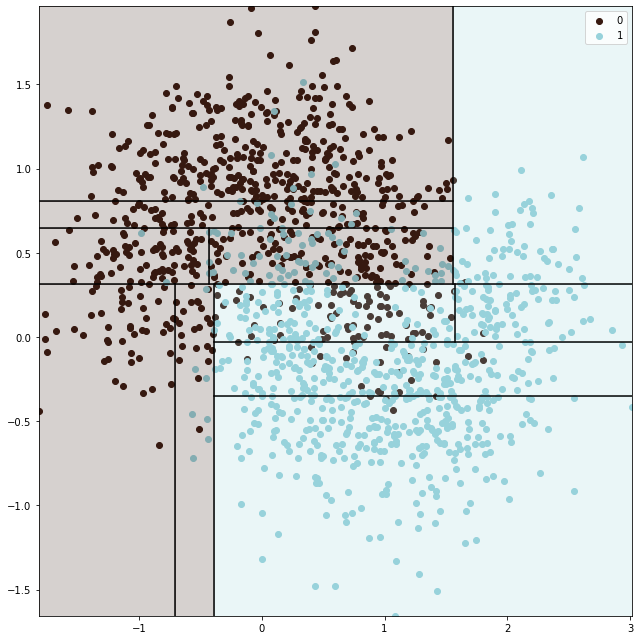

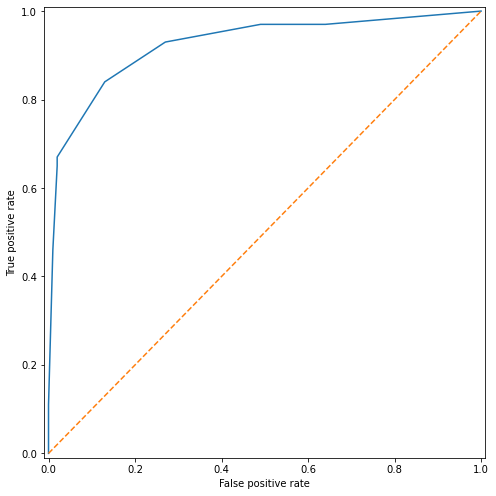

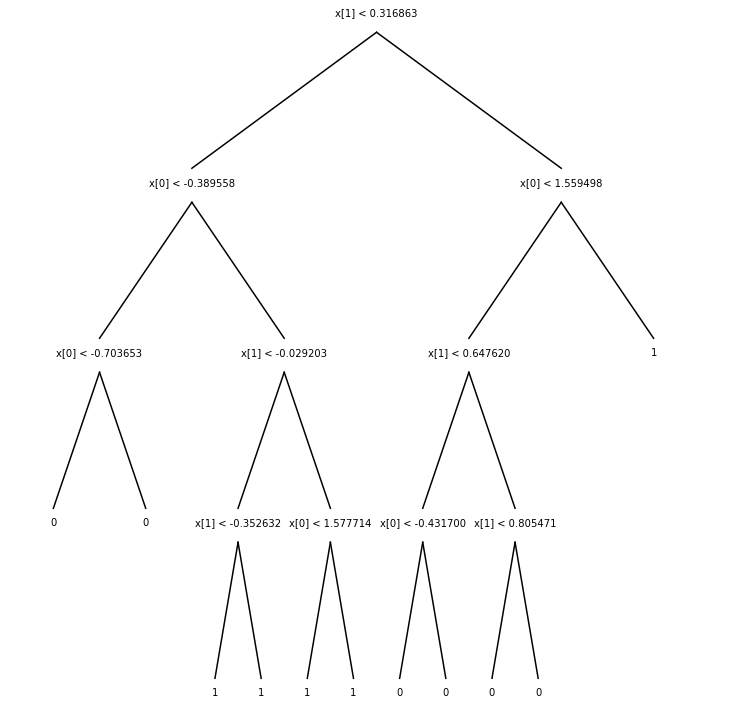

In [8]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

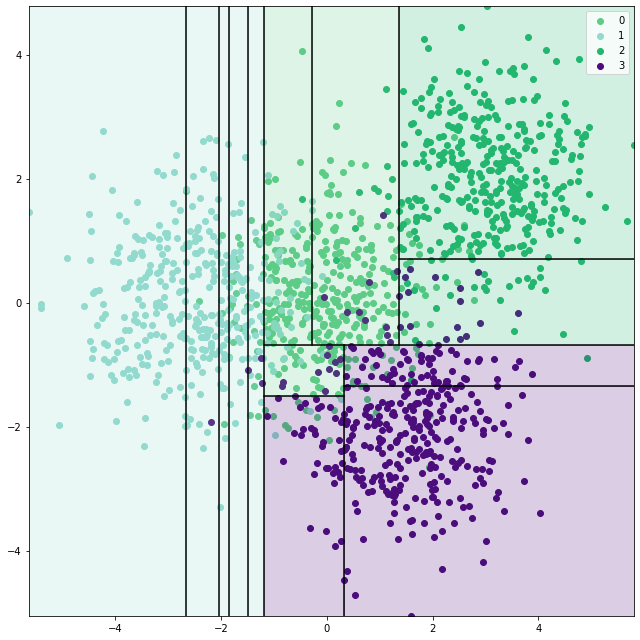

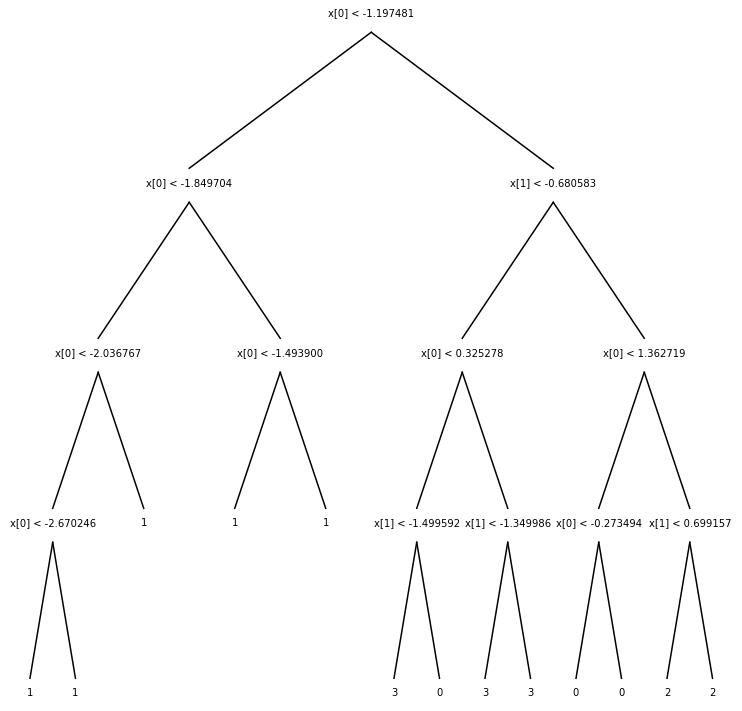

In [9]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Задание 4 (3 балла)
У малоизвестной MMORPG Smash Art Online удалилась часть базы данных, а бэкапа не оказалось. Уволив сисадмина, тимлид начал думать, как проще и быстрее разрешить ситуацию. Оказалось, что в основном пострадала информация о классах персонажей, но зато часть внутриигровой статистики осталась нетронутой. Было решено не перезапускать игровой мир, а попробовать восстановить утерянные данные.

Посчитав, что ручное восстановление классов персонажей было бы очень долгим и вызвало бы недовольство игроков, тимлид решил пригласить специалиста по машинному обучению, который смог бы восстановить большую часть данных автоматически. 

Ваша задача - построить дерево решений, которое как можно более точно восстанавливает класс персонажа. В этом вам поможет статистика персонажей, а так же сохранившаяся часть классов персонажей. Чтобы дерево было достаточно интерпретируемым, его высота должна быть не больше `6`.


#### Оценка задания
Баллы за это задание выставляются в зависимости от точности полученного классификатора на закрытой части выборки:
1. __Точность > 50%__ - 1 балл - классификатор значительно облегчил команде игры задачу по восстановлению классов игроков. Тимлид доволен и, вероятно, захочет продолжить сотрудничество в дальнейшем
2. __Точность > 85%__ - 3 балла - классификатор сделал большую часть работы. Довольный тимлид задумчиво чешет подбородок, а затем предлагает сотрудничество на постоянной основе

__Важно: метки классов - названия, а не числа. Пусть так и остается.__

In [10]:
def read_dataset(path):
    dataframe = pandas.read_csv(path, header=1)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y)

In [11]:
df = pandas.read_csv("train.csv")
df.head()

,class,monster kills per death,death in pvp percentage,player kills per death,accuracy
0,cleric,0.565891,0.038949,0.374648,0.831516
1,cleric,1.018481,0.215307,0.147939,0.174042
2,cleric,0.744537,0.313720,0.171784,0.567035
3,cleric,0.393450,0.118440,0.408182,0.709159
4,cleric,0.664187,0.141598,0.168503,0.859256


In [12]:
X, y = read_dataset("train.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

dtc = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, criterion="entropy")
dtc.fit(X_train, y_train)
pred_train = dtc.predict(X_train)
pred_test = dtc.predict(X_test)

In [13]:
print(f"Accuracy on train: {accuracy_score(y_train, pred_train):.4f}")
print(f"Accuracy on test: {accuracy_score(y_test, pred_test):.4f}")

Accuracy on train: 0.9228
Accuracy on test: 0.9083


### Задание 5 (1 балл)
От игроков начали поступать жалобы на то, что класс их персонажа внезапно сменился. В таких случаях модераторы смотрят на данные персонажа и пытаются восстановить его класс сами. Для того, чтобы им было проще это сделать, нужно научиться для каждого персонажа объяснять, почему дерево решений присвоило персонажу именно такой класс.

Реализуйте функцию `predict_explain(dtc, X)`. Для каждого элемента элемента набора данных `X` она должна вернуть пару из предсказанного класса и человекочетаемой строковой записи условий, благодаря которым был предсказан класс. 

In [14]:
def predict_explain(dtc: DecisionTreeClassifier, X: np.ndarray):
    feature_names = ['monster kills per death', 'death in pvp percentage', 'player kills per death', 'accuracy']
    
    def tree_walk(x, node, path):
        if isinstance(node, DecisionTreeLeaf):
            path.append(node.probs)
        else:
            path.append((node.split_dim, node.split_value))
            if x[node.split_dim] < node.split_value:
                tree_walk(x, node.left, path)
            else:
                tree_walk(x, node.right, path)
        return path
    
    y_pred = dtc.predict(X)
    result = []
    for i, (x, y) in enumerate(zip(X, y_pred)):
        path = tree_walk(x, dtc.root, [])
        explanation = f"Player {i + 1}. Class: {y_pred[i]}. Confidence: {100*path[-1][y_pred[i]]:.2f}%.\n  Info:\n"
        for j in range(len(feature_names)):
            explanation += f"{feature_names[j]} = {x[j]:.4f}\n"
        explanation += "  Reasons:\n"
        for split_dim, split_value in path[:-1]:
            explanation += f"    {feature_names[split_dim]} {'<' if x[split_dim] < split_value else '>='} {split_value:.4f}\n"
        result.append(explanation)
    return zip(y_pred, result)

In [16]:
X, y = read_dataset("train.csv")
explane_size = 20

X_train = X[:-explane_size]
y_train = y[:-explane_size]

X_explane = X[-explane_size:]
y_explane = y[-explane_size:]

dtc = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, criterion="entropy")
dtc.fit(X_train, y_train)

In [17]:
for pred_y, expl in predict_explain(dtc, X_explane):
    print("Class:", pred_y)
    print("Explanation:\n", expl)
    print()

Class: warrior
Explanation:
 Player 1. Class: warrior. Confidence: 75.51%.
  Info:
monster kills per death = 4.1519
death in pvp percentage = 0.8161
player kills per death = 0.3090
accuracy = 0.9094
  Reasons:
    death in pvp percentage >= 0.4864
    death in pvp percentage < 0.9169
    player kills per death < 2.4192
    death in pvp percentage < 0.8897
    accuracy >= 0.5023


Class: warrior
Explanation:
 Player 2. Class: warrior. Confidence: 100.00%.
  Info:
monster kills per death = 5.5247
death in pvp percentage = 0.8998
player kills per death = 0.1394
accuracy = 0.6769
  Reasons:
    death in pvp percentage >= 0.4864
    death in pvp percentage < 0.9169
    player kills per death < 2.4192
    death in pvp percentage >= 0.8897


Class: warrior
Explanation:
 Player 3. Class: warrior. Confidence: 100.00%.
  Info:
monster kills per death = 2.6290
death in pvp percentage = 0.6721
player kills per death = 1.7846
accuracy = 0.4824
  Reasons:
    death in pvp percentage >= 0.4864
    de